In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

import matplotlib.pyplot as plt

from pprint import pprint
from sklearn.preprocessing import LabelEncoder, StandardScaler

##### Load Used Cars dataset

In [2]:
df = pd.read_csv('cars.csv')

In [3]:
# Check shape of data
print(f'# of rows = {df.shape[0]}')
print(f'# of cols = {df.shape[1]}')

# of rows = 38531
# of cols = 30


In [4]:
# Check for any null values
print('columns that contain null values')
print('='*35)
for col in df.columns[df.isna().any() == True]:
    print(col, df[col].dtype)
    

columns that contain null values
engine_capacity float64


Only column that contains null values is `engine_capacity`, which is a numerical column. We wont do any preprocessing on numerical data since we are focusing on only categorical data for this assigment.

##### Find Categorical Columns

In [5]:
# Looking at the Kaggle data card for this dataset
# I saw that there are features that have True/False values
# So thats why I have a check for the bool data type as well
cat_cols  = df.columns[(df.dtypes == object) | (df.dtypes == bool)].values

print(f'# of categorical columns = {len(cat_cols)}')
print(df.loc[:, cat_cols].dtypes)

# of categorical columns = 23
manufacturer_name    object
model_name           object
transmission         object
color                object
engine_fuel          object
engine_has_gas         bool
engine_type          object
body_type            object
has_warranty           bool
state                object
drivetrain           object
is_exchangeable        bool
location_region      object
feature_0              bool
feature_1              bool
feature_2              bool
feature_3              bool
feature_4              bool
feature_5              bool
feature_6              bool
feature_7              bool
feature_8              bool
feature_9              bool
dtype: object


## Preprocess categorical columns

1. Frequency Binning
2. Label Encoding
3. Standard Scaling

### Frequency Binning

Looking at the data card of the Kaggle dataset, you can see that the following categorical features have high cardinality:
- `manufacturer_name_`
- `model_name`

Furthermore, these features contain levels that are >0.005% of the total amount of observations of that feature, commonly referred to as rare levels. To address this issue for the two features mentioned above, frequency binning is being applied. Although, the implementation below is generalized for all categorical features that have rare levels. The steps of applying frequency binning to a categorical feature are defined as follows:
1. For each level, calculate Frequency (F = # occurences / total # of observations)
2. If frequency is below a threshold, change all occurences of level named 'other'

In [6]:
def calc_frequency(series: pd.Series):
    '''
    Function for calculating the frequency of each unique value in the series.
    '''

    # Calculate frequencies of each level
    # Frequency = # of occurences of level / total # of observations
    freqs = {
        level: len(np.where(series == level)[0]) / len(series)
            for level in series.unique()
    }

    return freqs

In [7]:
def bin_by_frequency(series: pd.Series, thresh: float=0.005, verbose: bool=False):
    '''
    Function for binning low occuring levels in a series of categorical data.
    '''
    # Calculate frequency of each unique level
    freqs = calc_frequency(series)

    # Get levels that have a frequency below the specified threshold
    rare_levels = {
        k:v for k,v in freqs.items() if v < thresh
    }

    # Create mapping dictionary to convert the rare occuring levels to a class called 'other'
    other_map = {
        k:'other' for k in rare_levels.keys()
    }

    # Verbose flag for printing data when debugging
    if verbose: pprint(rare_levels)

    return series.replace(other_map)

In [8]:
class FrequencyBinning():
    '''
    Wrapper class for applying the frequency binning functions like sklearn transformer classes.
    
    Example:
    ```
    bin = FrequencyBinning(threshold=0.005)
    df_binned = bin.fit_transform(df)
    ```
    '''
    def __init__(self, threshold: float=0.005):
        self.threshold = threshold

    def fit(self, X=None, y=None):
        return self

    def transform(self, X:pd.DataFrame, y=None):
        for col in X.columns:
            series = X.loc[:, col]
            X.loc[:, col] = bin_by_frequency(series, self.threshold)
        
        return X
    
    def fit_transform(self, X:pd.DataFrame, y=None):
        return self.fit().transform(X)
        

In [9]:
# Copy df with unprocessed data
df_binned = df.copy()

In [10]:
# Bin by Frequency
freq_binner = FrequencyBinning(threshold=0.005)
df_binned.loc[:, cat_cols] = freq_binner.fit_transform(df_binned[cat_cols])

### Label Encoding

class_0, class_1, class_n -> 0, 1, ..., n

For keeping the dimensionality of the data the same (i.e 30 features), label encoding will be applied to each categorical feature

In [11]:
df_encoded = df_binned.copy()

In [12]:
# Label Encode all categorical features
df_encoded[cat_cols] = df_encoded[cat_cols].apply(LabelEncoder().fit_transform)

### Standard Scaling

Now that all of the categorical features are converted into numerical format, standardizing all the features is recommended so that all of the features have the same range.

In [13]:
df_scaled = df_encoded.copy()

In [14]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_encoded.columns)

### Visualize results of preprocessing

In [15]:
print('Unprocessed')
display(df[cat_cols])
print('\n\n\n')

print('After frequency binning')
display(df_binned[cat_cols])
print('\n\n\n')

print('After label encoding')
display(df_encoded[cat_cols])
print('\n\n\n')

print('After standard scaling')
display(df_scaled[cat_cols])
print('\n\n\n')

Unprocessed


,manufacturer_name,model_name,transmission,color,engine_fuel,engine_has_gas,engine_type,body_type,has_warranty,state,drivetrain,is_exchangeable,location_region,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
0,Subaru,Outback,automatic,silver,gasoline,False,gasoline,universal,False,owned,all,False,Минская обл.,False,True,True,True,False,True,False,True,True,True
1,Subaru,Outback,automatic,blue,gasoline,False,gasoline,universal,False,owned,all,True,Минская обл.,False,True,False,False,True,True,False,False,False,True
2,Subaru,Forester,automatic,red,gasoline,False,gasoline,suv,False,owned,all,True,Минская обл.,False,True,False,False,False,False,False,False,True,True
3,Subaru,Impreza,mechanical,blue,gasoline,False,gasoline,sedan,False,owned,all,True,Минская обл.,True,False,False,False,False,False,False,False,False,False
4,Subaru,Legacy,automatic,black,gasoline,False,gasoline,universal,False,owned,all,True,Гомельская обл.,False,True,False,True,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38526,Chrysler,300,automatic,silver,gasoline,False,gasoline,sedan,False,owned,front,True,Минская обл.,False,True,False,False,True,True,False,False,True,True
38527,Chrysler,PT Cruiser,mechanical,blue,diesel,False,diesel,hatchback,False,owned,front,True,Брестская обл.,False,True,False,False,True,True,False,False,True,True
38528,Chrysler,300,automatic,blue,gasoline,False,gasoline,sedan,False,owned,front,False,Минская обл.,False,True,False,False,True,True,False,False,True,True
38529,Chrysler,PT Cruiser,mechanical,black,gasoline,False,gasoline,minivan,False,owned,front,True,Брестская обл.,False,True,False,False,False,False,False,False,False,True






After frequency binning


,manufacturer_name,model_name,transmission,color,engine_fuel,engine_has_gas,engine_type,body_type,has_warranty,state,drivetrain,is_exchangeable,location_region,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
0,Subaru,other,automatic,silver,gasoline,False,gasoline,universal,False,owned,all,False,Минская обл.,False,True,True,True,False,True,False,True,True,True
1,Subaru,other,automatic,blue,gasoline,False,gasoline,universal,False,owned,all,True,Минская обл.,False,True,False,False,True,True,False,False,False,True
2,Subaru,other,automatic,red,gasoline,False,gasoline,suv,False,owned,all,True,Минская обл.,False,True,False,False,False,False,False,False,True,True
3,Subaru,other,mechanical,blue,gasoline,False,gasoline,sedan,False,owned,all,True,Минская обл.,True,False,False,False,False,False,False,False,False,False
4,Subaru,other,automatic,black,gasoline,False,gasoline,universal,False,owned,all,True,Гомельская обл.,False,True,False,True,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38526,Chrysler,other,automatic,silver,gasoline,False,gasoline,sedan,False,owned,front,True,Минская обл.,False,True,False,False,True,True,False,False,True,True
38527,Chrysler,other,mechanical,blue,diesel,False,diesel,hatchback,False,owned,front,True,Брестская обл.,False,True,False,False,True,True,False,False,True,True
38528,Chrysler,other,automatic,blue,gasoline,False,gasoline,sedan,False,owned,front,False,Минская обл.,False,True,False,False,True,True,False,False,True,True
38529,Chrysler,other,mechanical,black,gasoline,False,gasoline,minivan,False,owned,front,True,Брестская обл.,False,True,False,False,False,False,False,False,False,True






After label encoding


,manufacturer_name,model_name,transmission,color,engine_fuel,engine_has_gas,engine_type,body_type,has_warranty,state,drivetrain,is_exchangeable,location_region,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
0,24,37,0,7,2,0,1,8,0,2,0,0,4,0,1,1,1,0,1,0,1,1,1
1,24,37,0,1,2,0,1,8,0,2,0,1,4,0,1,0,0,1,1,0,0,0,1
2,24,37,0,6,2,0,1,7,0,2,0,1,4,0,1,0,0,0,0,0,0,1,1
3,24,37,1,1,2,0,1,6,0,2,0,1,4,1,0,0,0,0,0,0,0,0,0
4,24,37,0,0,2,0,1,8,0,2,0,1,2,0,1,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38526,4,37,0,7,2,0,1,6,0,2,1,1,4,0,1,0,0,1,1,0,0,1,1
38527,4,37,1,1,0,0,0,1,0,2,1,1,0,0,1,0,0,1,1,0,0,1,1
38528,4,37,0,1,2,0,1,6,0,2,1,0,4,0,1,0,0,1,1,0,0,1,1
38529,4,37,1,0,2,0,1,4,0,2,1,1,0,0,1,0,0,0,0,0,0,0,1






After standard scaling


,manufacturer_name,model_name,transmission,color,engine_fuel,engine_has_gas,engine_type,body_type,has_warranty,state,drivetrain,is_exchangeable,location_region,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
0,0.930164,0.644829,-1.409738,0.942954,0.736650,-0.190329,0.707122,1.167851,-0.108583,0.138335,-1.890685,-0.737996,0.508293,-0.544288,0.804304,1.862225,1.620421,-0.564213,1.344761,-0.454139,1.670831,1.186481,0.852005
1,0.930164,0.644829,-1.409738,-0.963570,0.736650,-0.190329,0.707122,1.167851,-0.108583,0.138335,-1.890685,1.355021,0.508293,-0.544288,0.804304,-0.536992,-0.617124,1.772382,1.344761,-0.454139,-0.598505,-0.842829,0.852005
2,0.930164,0.644829,-1.409738,0.625200,0.736650,-0.190329,0.707122,0.774298,-0.108583,0.138335,-1.890685,1.355021,0.508293,-0.544288,0.804304,-0.536992,-0.617124,-0.564213,-0.743627,-0.454139,-0.598505,1.186481,0.852005
3,0.930164,0.644829,0.709351,-0.963570,0.736650,-0.190329,0.707122,0.380745,-0.108583,0.138335,-1.890685,1.355021,0.508293,1.837264,-1.243310,-0.536992,-0.617124,-0.564213,-0.743627,-0.454139,-0.598505,-0.842829,-1.173702
4,0.930164,0.644829,-1.409738,-1.281324,0.736650,-0.190329,0.707122,1.167851,-0.108583,0.138335,-1.890685,1.355021,-0.938592,-0.544288,0.804304,-0.536992,1.620421,1.772382,-0.743627,-0.454139,-0.598505,-0.842829,0.852005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38526,-1.293536,0.644829,-1.409738,0.942954,0.736650,-0.190329,0.707122,0.380745,-0.108583,0.138335,-0.000540,1.355021,0.508293,-0.544288,0.804304,-0.536992,-0.617124,1.772382,1.344761,-0.454139,-0.598505,1.186481,0.852005
38527,-1.293536,0.644829,0.709351,-0.963570,-1.379022,-0.190329,-1.410891,-1.587021,-0.108583,0.138335,-0.000540,1.355021,-2.385476,-0.544288,0.804304,-0.536992,-0.617124,1.772382,1.344761,-0.454139,-0.598505,1.186481,0.852005
38528,-1.293536,0.644829,-1.409738,-0.963570,0.736650,-0.190329,0.707122,0.380745,-0.108583,0.138335,-0.000540,-0.737996,0.508293,-0.544288,0.804304,-0.536992,-0.617124,1.772382,1.344761,-0.454139,-0.598505,1.186481,0.852005
38529,-1.293536,0.644829,0.709351,-1.281324,0.736650,-0.190329,0.707122,-0.406361,-0.108583,0.138335,-0.000540,1.355021,-2.385476,-0.544288,0.804304,-0.536992,-0.617124,-0.564213,-0.743627,-0.454139,-0.598505,-0.842829,0.852005


# Visualize results of classes that were affected by binning

In [30]:
def print_binning_changes(col, df, df_binned):
    len1 = len(df[col].unique())
    len2 = len(df_binned[col].unique())
    diff = abs(len1 - len2)

    print(f'column = {col}' )
    print(f'# of levels before = {len1}')
    print(f'# of levels after  = {len2}')
    print(f'# of levels binned = {diff}')

In [31]:
print_binning_changes('model_name', df, df_binned)
print()
print_binning_changes('manufacturer_name', df, df_binned)


column = model_name
# of levels before = 1118
# of levels after  = 38
# of levels binned = 1080

column = manufacturer_name
# of levels before = 55
# of levels after  = 32
# of levels binned = 23


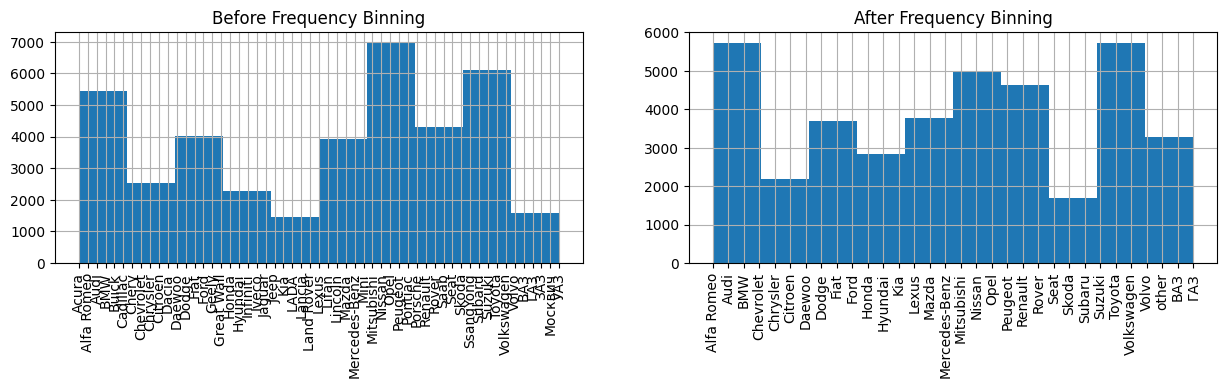

In [18]:
col = 'manufacturer_name'

plt.figure(1, figsize=(15, 3))

ax1 = plt.subplot(1, 2, 1)
ax1.set_title('Before Frequency Binning')
df[col].sort_values().hist()
plt.xticks(rotation = 90)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('After Frequency Binning')
df_binned[col].sort_values().hist()
plt.xticks(rotation = 90);

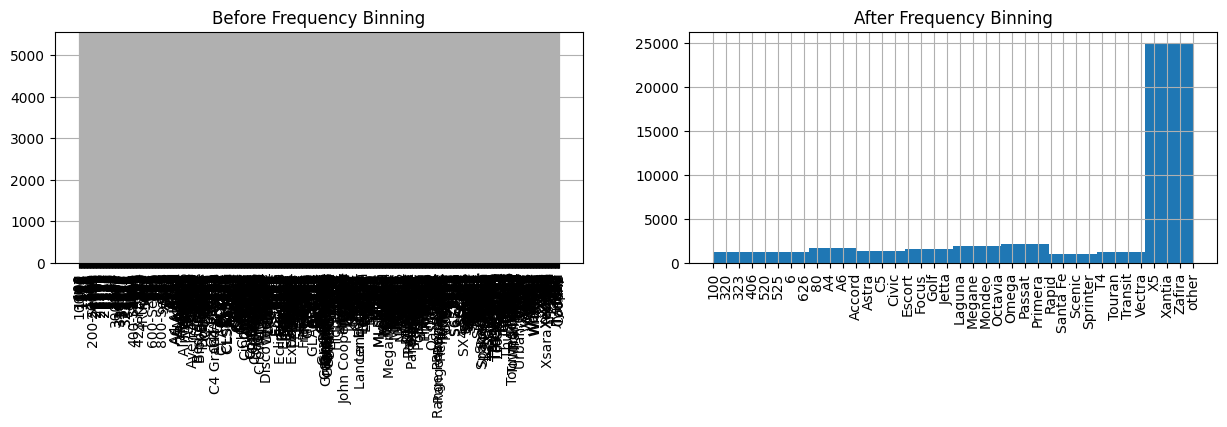

In [19]:
col = 'model_name'

plt.figure(1, figsize=(15, 3))

ax1 = plt.subplot(1, 2, 1)
ax1.set_title('Before Frequency Binning')
df[col].sort_values().hist()
plt.xticks(rotation = 90)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('After Frequency Binning')
df_binned[col].sort_values().hist()
plt.xticks(rotation = 90);

**Note on plot above**

The cardinality of the `model_name` feature is extremely high, making it very difficult to see the distribution of levels before binning. Applying Frequency binning has resulted in high